In [2]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution

<function tensorflow.python.framework.ops.enable_eager_execution(config=None, device_policy=None, execution_mode=None) -> None>

In [3]:
import tensorflow as tf
print("Eager execution is enabled:", tf.executing_eagerly())


Eager execution is enabled: True


In [25]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD  
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import numpy as np
import keras_tuner
from sklearn.preprocessing import StandardScaler
import shutil
import keras
import keras_tuner as kt
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import os

In [26]:
my_data = np.genfromtxt('ML-CUP24-TR.csv', delimiter=',')
X = my_data[:, 1:13]
y = my_data[:, 13:16]
print(X.shape, y.shape)

(250, 12) (250, 3)


In [27]:
m_features = 12

my_data = np.genfromtxt('ML-CUP24-TR.csv', delimiter=',')
X=my_data[:, 1:13]
Y=my_data[:, 13:16]

from sklearn.model_selection import train_test_split

train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=1 - train_ratio)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

scalerX = StandardScaler().fit(x_train)
scalerY = StandardScaler().fit(y_train)

x_train = scalerX.transform(x_train)
x_val = scalerX.transform(x_val)
x_test = scalerX.transform(x_test)

y_train = scalerY.transform(y_train)
y_val = scalerY.transform(y_val)
y_test = scalerY.transform(y_test)

In [35]:

# Supponiamo che X e y siano i tuoi dati di input e target
# X, y = ... (definisci il tuo dataset qui)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Percorso per i log di TensorBoard
log_dir = "/tmp/tb_logs/keras_tuner"
os.makedirs(log_dir, exist_ok=True)

# Definizione del modello con intervalli per i parametri
def nn_model(param):
    # Definisci intervallo per il numero di unità nei layer nascosti
    neurons_layer1 = param.Int('neurons_layer1', min_value=8, max_value=32, step=1)
    neurons_layer2 = param.Int('neurons_layer2', min_value=8, max_value=32, step=1)
    neurons_layer3 = param.Int('neurons_layer3', min_value=8, max_value=32, step=1)
    batch_size = param.Int('batch_size', min_value=42, max_value=280, step=1)
    
    # Definisci intervallo per il learning rate (valore continuo)
    learning_rate = param.Float('learning_rate', min_value=0.00001, max_value=0.001, step=0.000001)

    model = Sequential([
        Dense(neurons_layer1, activation='relu', input_dim=X_train.shape[1]),
        Dense(neurons_layer2, activation='relu'),
        Dense(neurons_layer3, activation='relu'),
        Dense(3, activation='linear')  # Output layer per 3 valori continui
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# Configurazione di Hyperband per la ricerca degli iperparametri
tuner = kt.Hyperband(
    nn_model,
    objective='val_loss',
    max_epochs=70,  # Numero massimo di epoche
    factor=3,  # Controlla la quantità di risorse esplorate
    project_name='nn_param_search',
    executions_per_trial=1,
)

# Callback di TensorBoard per il monitoraggio durante il training
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Ricerca degli iperparametri con Hyperband
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Numero di epoche da allenare per ogni configurazione
    callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],
    verbose=1
)

# Recupero dei migliori iperparametri
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Migliori iperparametri trovati: Layer 1: {best_hps.get('neurons_layer1')}, "
      f"Layer 2: {best_hps.get('neurons_layer2')}, "
      f"Layer 3: {best_hps.get('neurons_layer3')}, "
      f"Learning Rate: {best_hps.get('learning_rate')}.")

# Costruzione e allenamento del miglior modello
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=best_hps['batch_size'],  # Utilizzare il miglior batch_size se trovato
    callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],
    verbose=1
)


Trial 90 Complete [00h 00m 13s]
val_loss: 0.4634127914905548

Best val_loss So Far: 0.26141032576560974
Total elapsed time: 00h 12m 45s
Migliori iperparametri trovati: Layer 1: 31, Layer 2: 23, Layer 3: 29, Learning Rate: 0.000896.
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 59.1682 - mae: 4.2676 - val_loss: 48.5427 - val_mae: 3.8170
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 57.5596 - mae: 4.2098 - val_loss: 47.5894 - val_mae: 3.7837
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 55.9716 - mae: 4.1431 - val_loss: 46.6278 - val_mae: 3.7505
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 55.3017 - mae: 4.1315 - val_loss: 45.7084 - val_mae: 3.7194
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 53.5294 - mae: 4.0674 - val_loss: 44.8090 - val_mae: 3.6892
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 52.3650 - mae: 4.0279 - val_loss: 43.9208 - val_mae: 3.6593
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5

In [36]:
%reload_ext tensorboard
%tensorboard --logdir /tmp/tb_logs

Reusing TensorBoard on port 6006 (pid 17092), started 2:50:33 ago. (Use '!kill 17092' to kill it.)

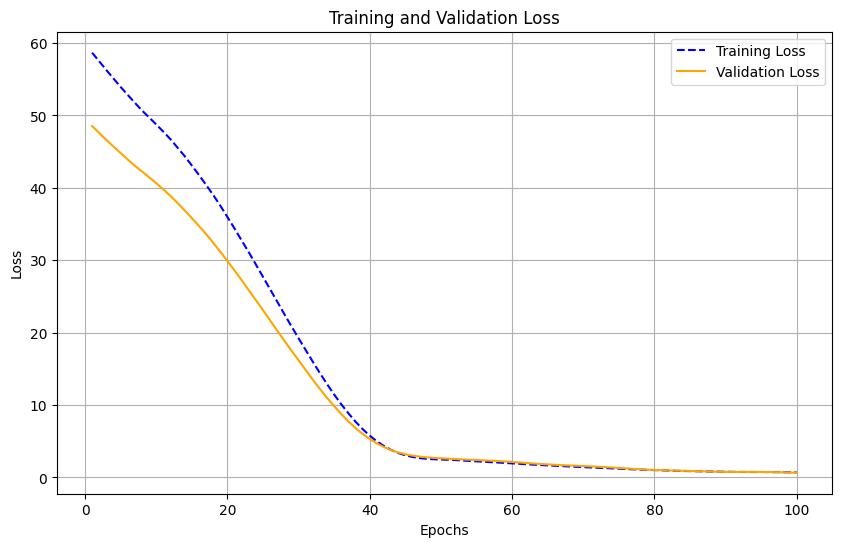

In [37]:
import matplotlib.pyplot as plt

ìtrain_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', linestyle='--')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
